# Hourly Energy Consumption 
### Time Series Analysis & Forecasting

In [5]:
# Load Modules
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (18, 18)

# Load Data
duq_df = pd.read_csv('data/DUQ_hourly.csv', index_col=[0], parse_dates=[0])

# Sort Data
duq_df.sort_index(inplace=True)

### Manage Duplicate Measurements

In [6]:
# Identify Duplicate Indices
duplicate_index = duq_df[duq_df.index.duplicated()]
duq_df.loc[duplicate_index.index.values, :]

,DUQ_MW
Datetime,
2014-11-02 02:00:00,1272.0
2014-11-02 02:00:00,1240.0
2015-11-01 02:00:00,1113.0
2015-11-01 02:00:00,1138.0
2016-11-06 02:00:00,1121.0
2016-11-06 02:00:00,1107.0
2017-11-05 02:00:00,1131.0
2017-11-05 02:00:00,1105.0


In [7]:
# Replace Duplicates with Mean Value
duq_df = duq_df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
duq_df = duq_df.asfreq('H')

### Impute Missing Values

In [8]:
# Determine # of Missing Values
print('# of Missing DUQ_MW Values: {}'.format(len(duq_df[duq_df['DUQ_MW'].isna()])))

# of Missing DUQ_MW Values: 24


In [9]:
# Impute Missing Values
duq_df['DUQ_MW'] = duq_df['DUQ_MW'].interpolate(limit_area='inside', limit=None)

## Create Features

In [10]:
def create_features(df):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df

duq_df = create_features(duq_df)

/var/folders/py/2jbm_8891md5c9454r3zz6700000gn/T/ipykernel_9765/807805489.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df['Date'].dt.weekofyear


## Basic Analysis - Visualizations
### Time Series Plot

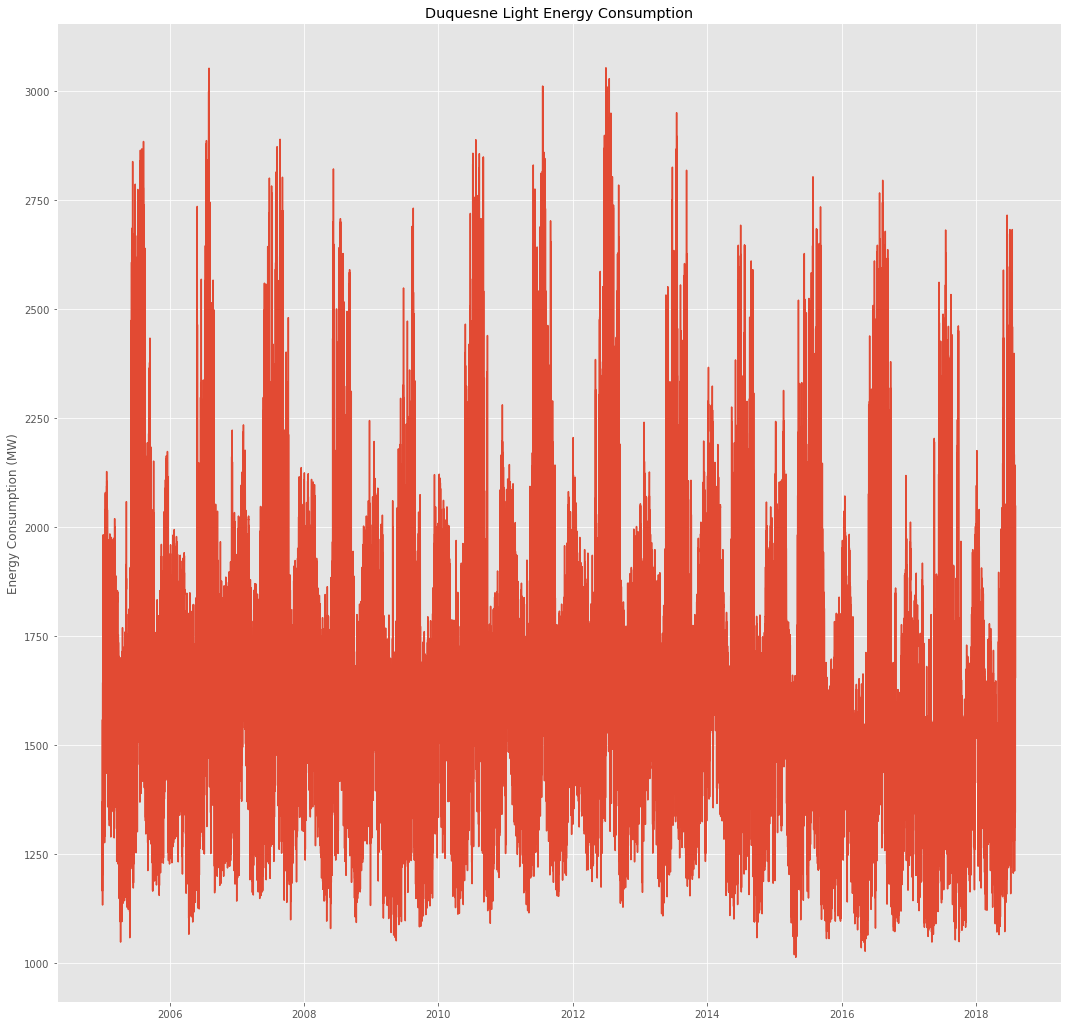

In [11]:
plt.plot(duq_df.index, duq_df['DUQ_MW'])
plt.title('Duquesne Light Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/time_series_plot.png')
plt.show()

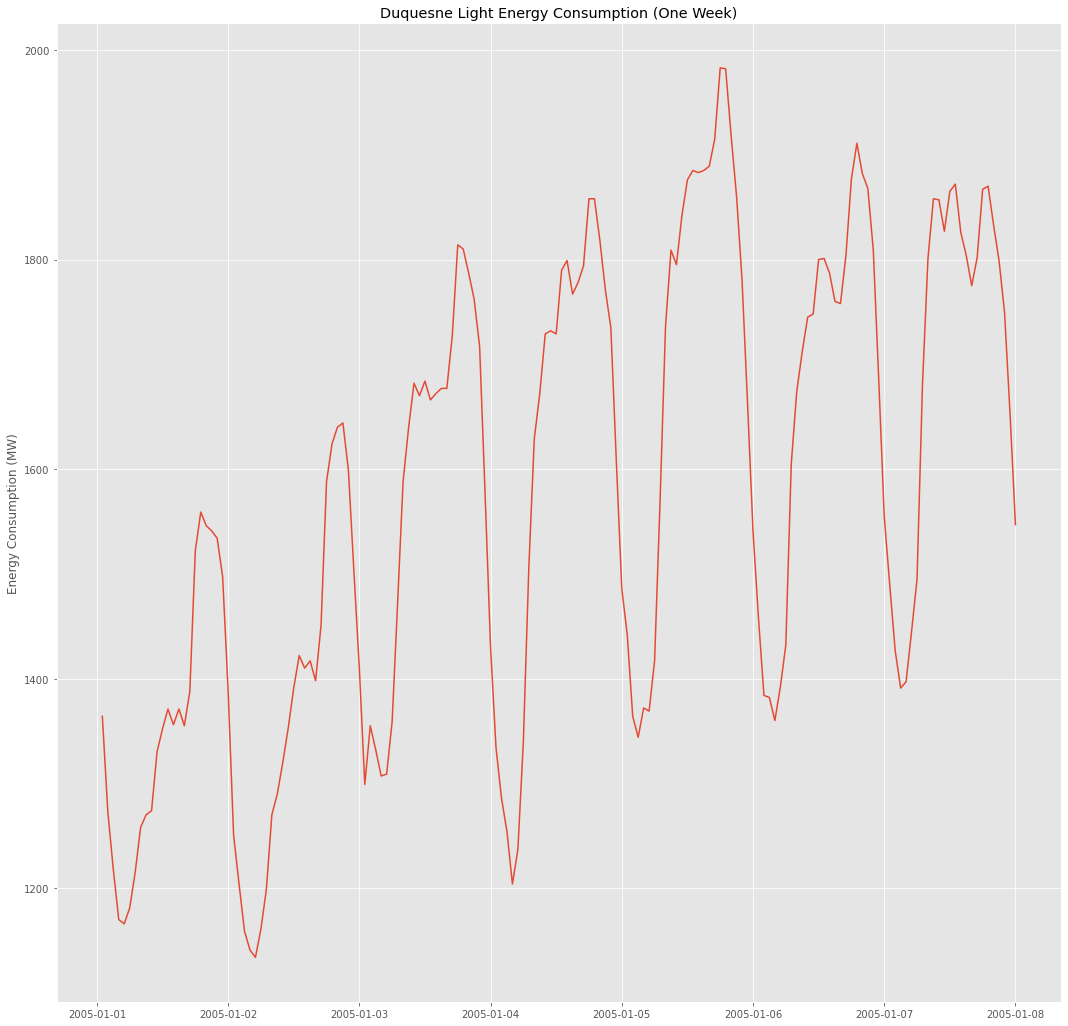

In [12]:
# One-Week Slice

WEEK_END_INDEX = 7*24
plt.plot(duq_df.index[:WEEK_END_INDEX], duq_df['DUQ_MW'][:WEEK_END_INDEX])
plt.title('Duquesne Light Energy Consumption (One Week)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/time_series_week_plot.png')
plt.show()

### Box Plots

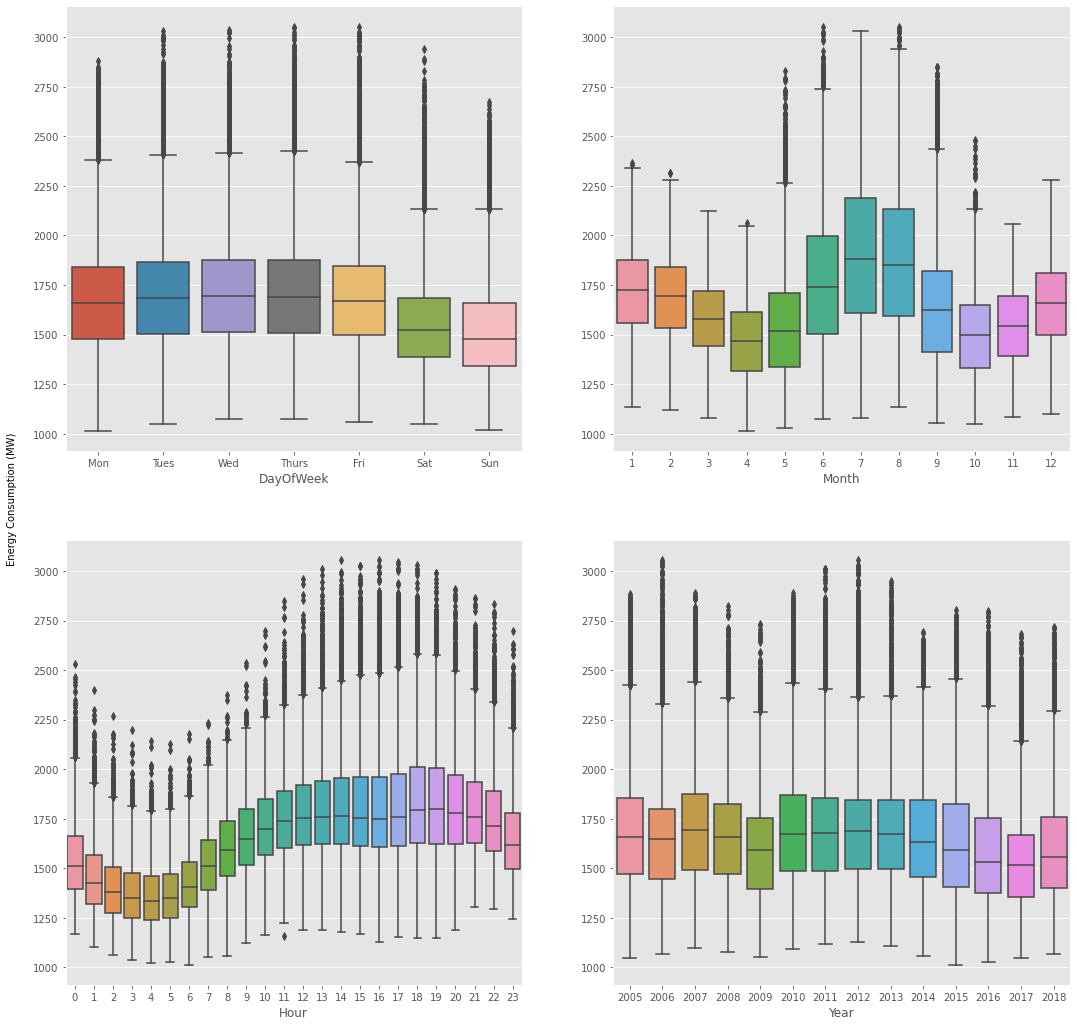

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=duq_df.DayOfWeek, y=duq_df.DUQ_MW, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=duq_df.Month, y=duq_df.DUQ_MW, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=duq_df.Hour, y=duq_df.DUQ_MW, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=duq_df.Year, y=duq_df.DUQ_MW, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.savefig('images/boxplots.png')
plt.show()

### Consumption Rate Histogram

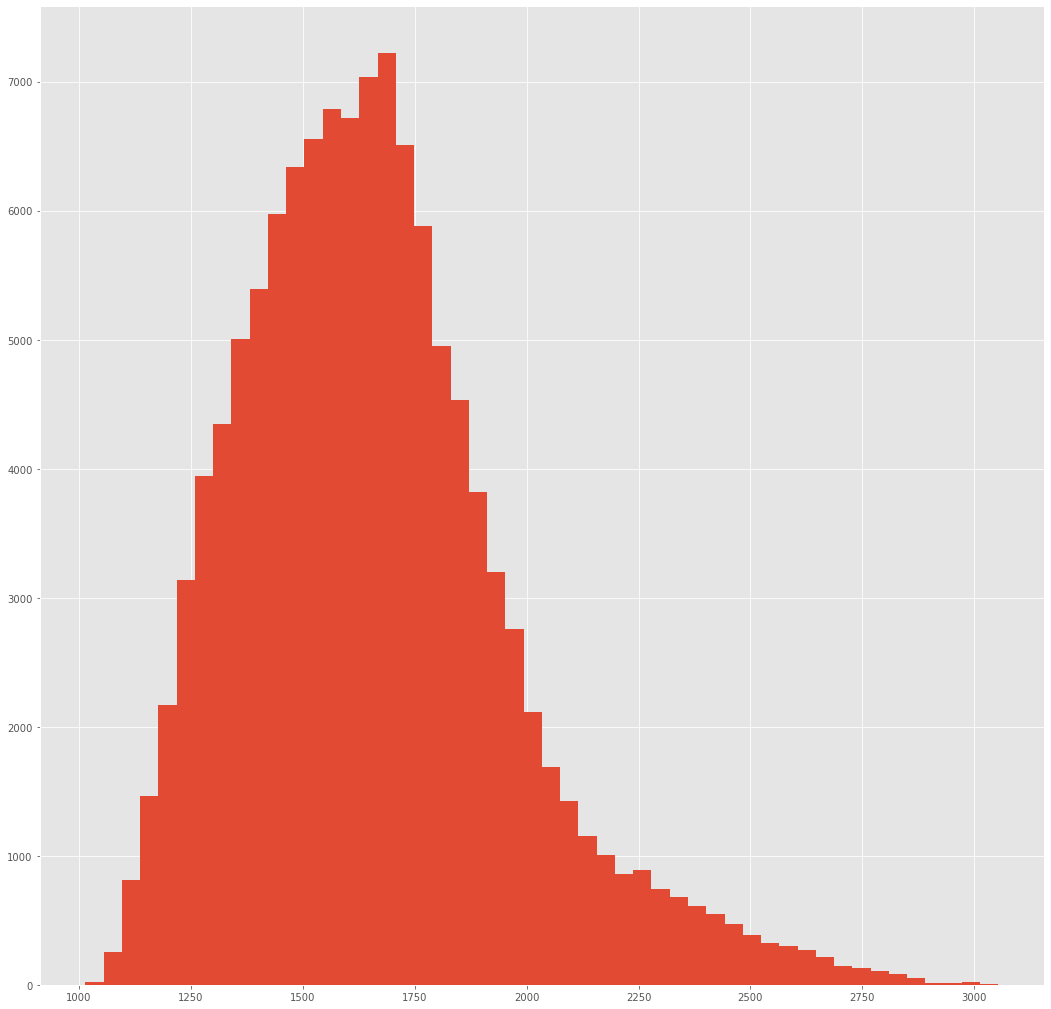

In [14]:
data_series = duq_df['DUQ_MW']
data_series.hist(bins=50)
plt.savefig('images/histogram.png')
plt.show()

### Seasonal Plot

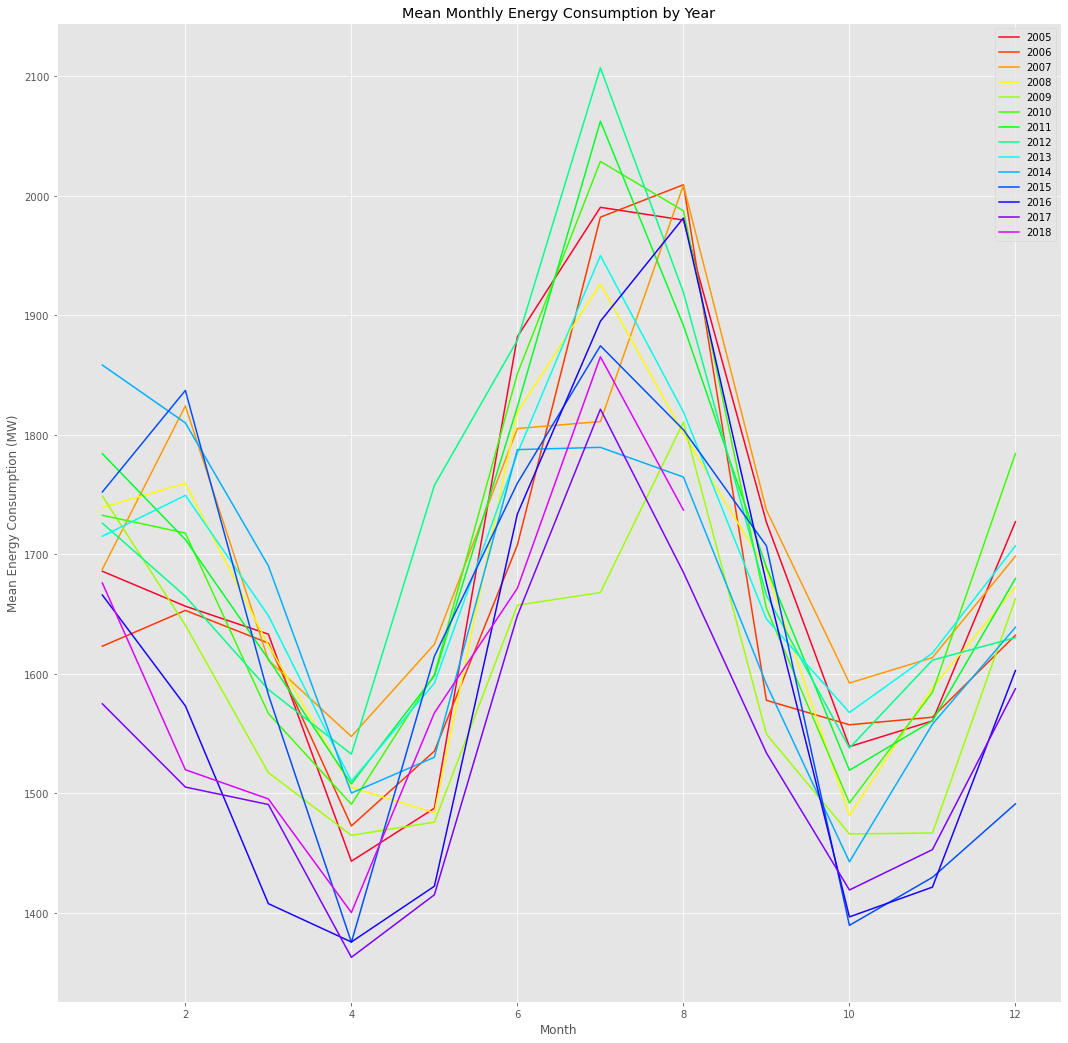

In [15]:
year_group = duq_df.groupby(['Year', 'Month']).mean().reset_index()
years = duq_df['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df = year_group[year_group['Year'] == y]
    #rolling_mean = df.DUQ_MW.rolling(window=7*24).mean()
    plt.plot(df['Month'], df['DUQ_MW'])
plt.title('Mean Monthly Energy Consumption by Year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(duq_df.Year.unique())
plt.savefig('images/seasonal_plot.png')
plt.show()

### Moving Average (Smoothing)

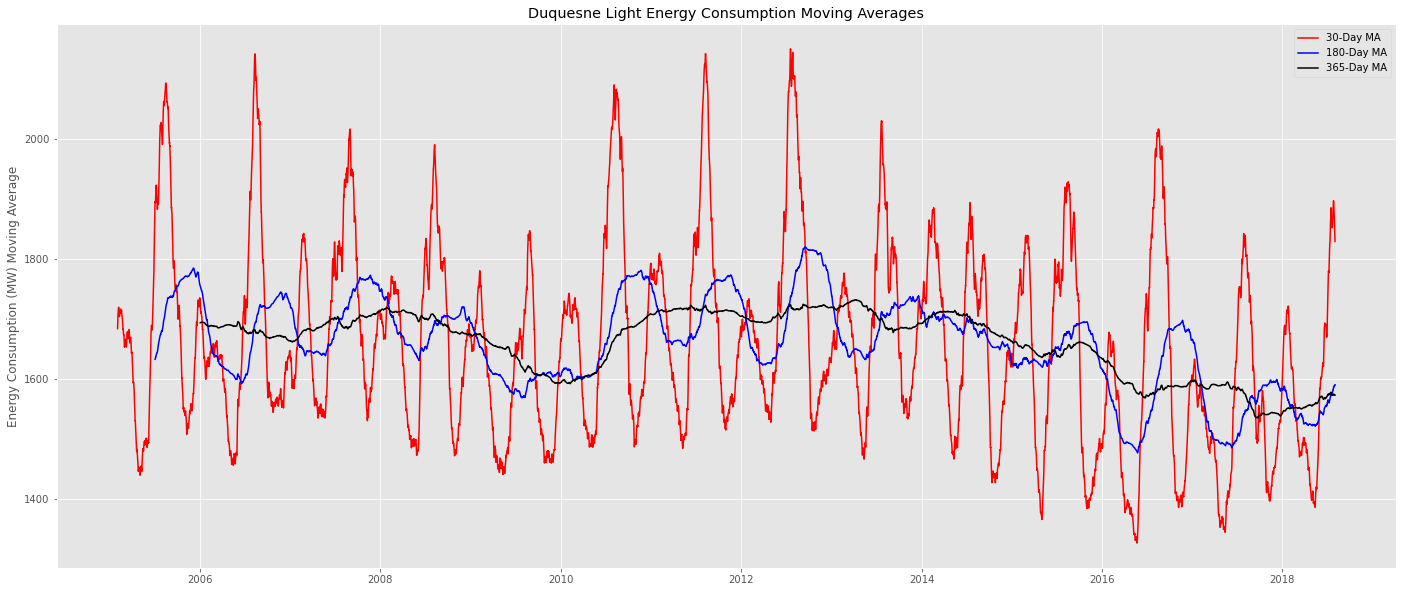

In [16]:
MONTH_PERIOD = 24*30
MIDYEAR_PERIOD = 24*182
YEAR_PERIOD = 24*365

month_roll = duq_df.rolling(MONTH_PERIOD).mean()
midyear_roll = duq_df.rolling(MIDYEAR_PERIOD).mean()
year_roll = duq_df.rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll['DUQ_MW'], color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll['DUQ_MW'], color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll['DUQ_MW'], color='black', label='365-Day MA')
plt.title('Duquesne Light Energy Consumption Moving Averages')
plt.ylabel('Energy Consumption (MW) Moving Average')
plt.legend()
plt.savefig('images/moving_average_smoothing.png')
plt.show()

### Seasonal Subplots

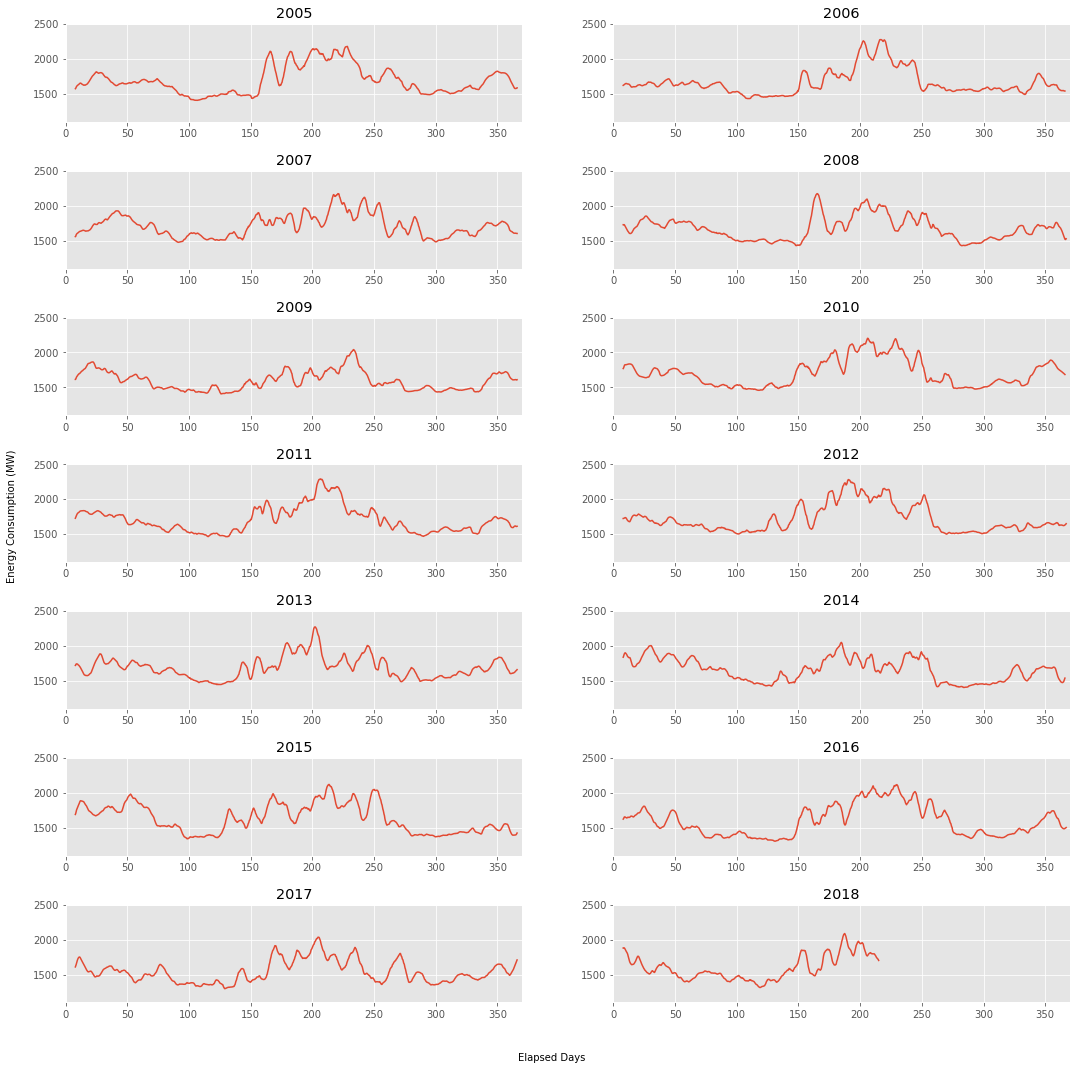

In [17]:
num_rows = 7
num_cols = 2
year_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
years = duq_df['Year'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = duq_df[duq_df['Year'] == years[year_index]]
        rolling_mean = df['DUQ_MW'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(years[year_index]))
        axes[i][j].set_ylim(1100, 2500)
        axes[i][j].set_xlim(0,370)
        year_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.savefig('images/seasonal_subplots.png')
plt.show()

## Classical Seasonal Decomposition
### Estimated Daily Amplitude

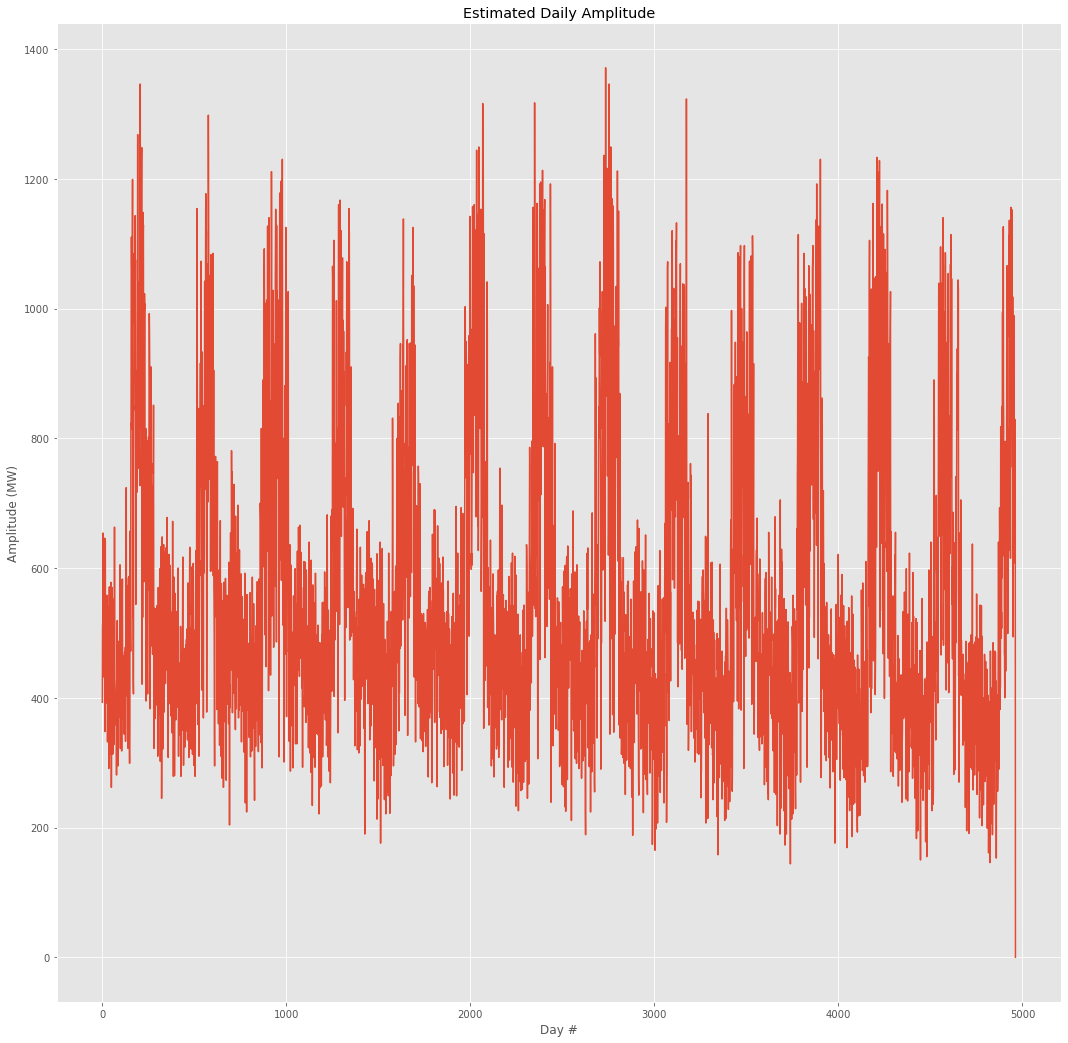

In [18]:
max_daily_vals = duq_df.groupby(['Year', 'DayOfYear']).max()['DUQ_MW'].values
min_daily_vals = duq_df.groupby(['Year', 'DayOfYear']).min()['DUQ_MW'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Amplitude (MW)')
plt.title('Estimated Daily Amplitude')
plt.savefig('images/daily_amplitude.png')
plt.show()

### Multiplicative Decomposition

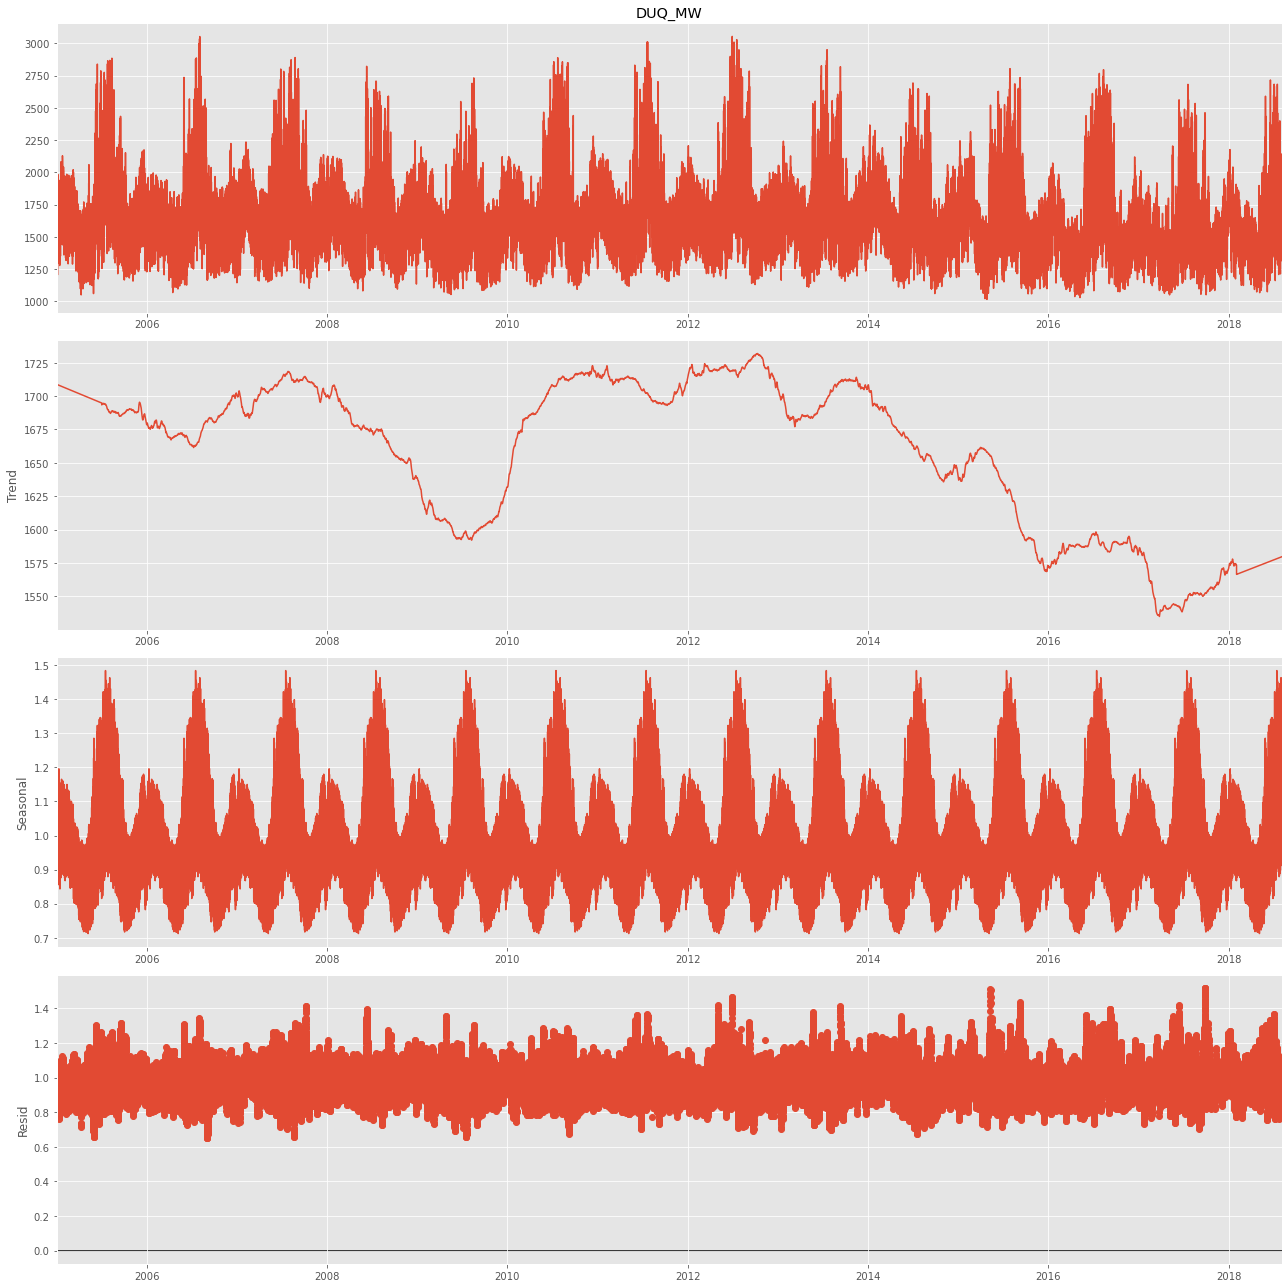

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

ANNUAL_PERIOD = 365*24
mult_decomp = seasonal_decompose(duq_df['DUQ_MW'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.savefig('images/multiplicative_decomp.png')
plt.show()

## Stationarity

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
# Augmented Dickey Fuller (ADF) Test

adf_result = adfuller(duq_df['DUQ_MW'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -17.62557149751052
p-value: 3.8201898004934586e-30


### Differencing

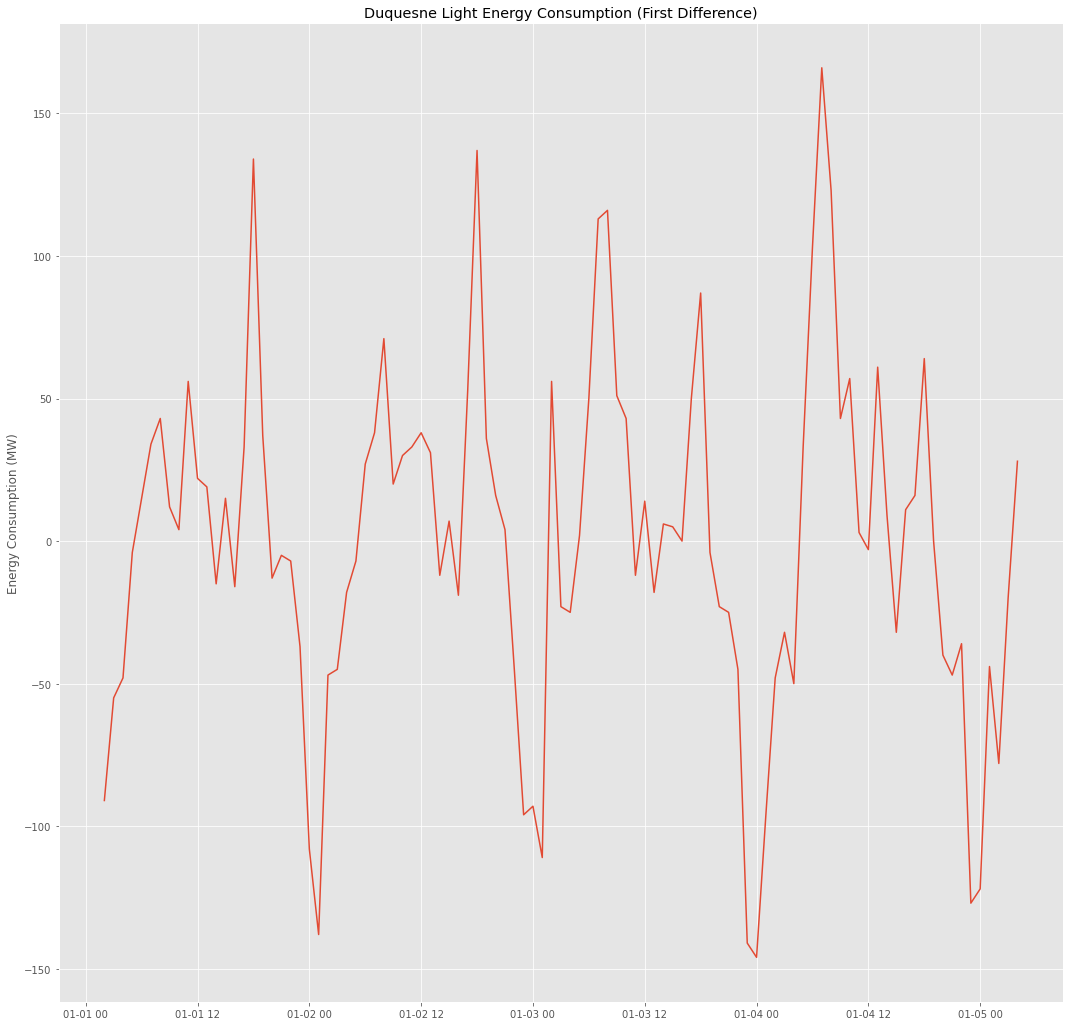

In [22]:
# First Difference (First 100 Values)
duq_df['first_difference'] = duq_df['DUQ_MW'] - duq_df['DUQ_MW'].shift(1)
plt.plot(duq_df.index[:100], duq_df['first_difference'][:100])
plt.title('Duquesne Light Energy Consumption (First Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/first_difference.png')
plt.show()

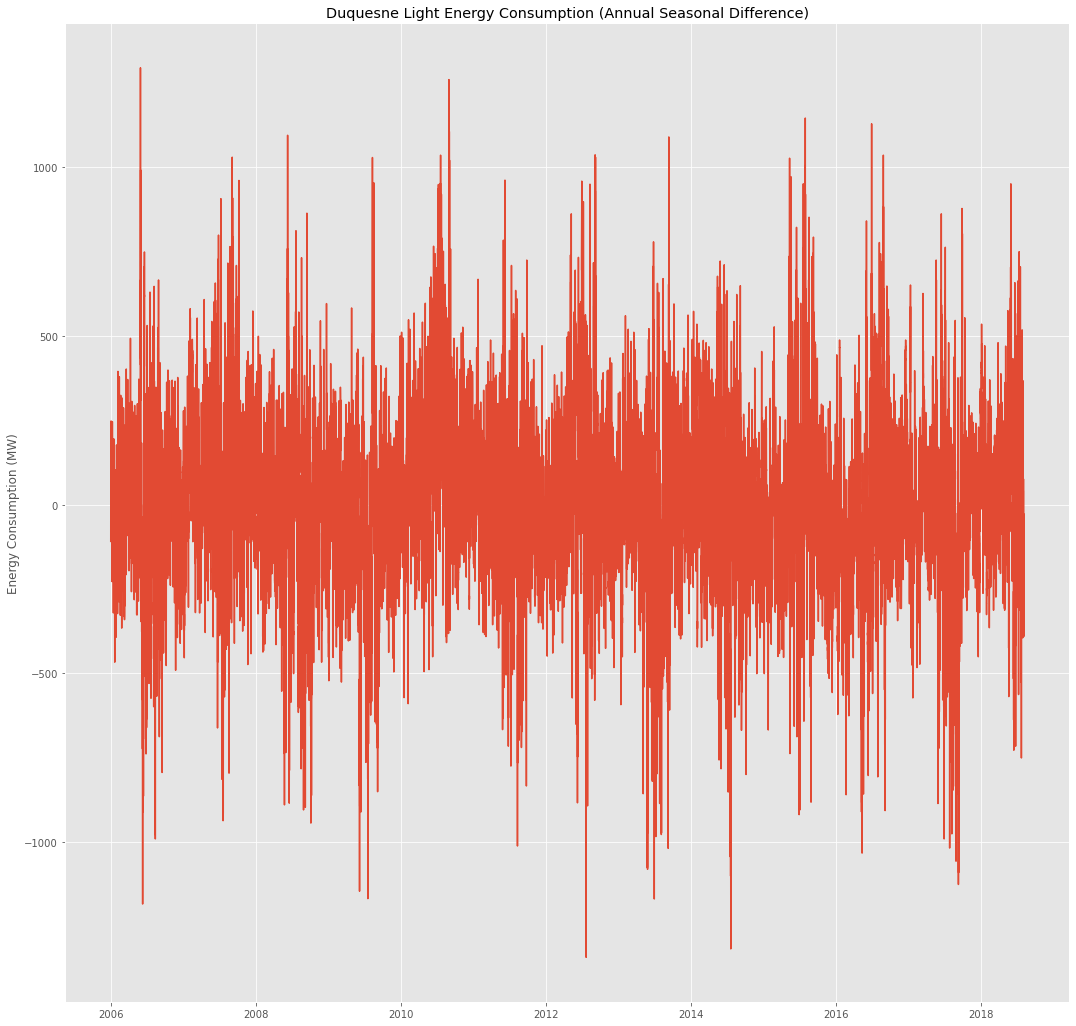

In [23]:
# Annual Seasonal Difference (First 1000 Values)
ANNUAL_SHIFT = 24*365

duq_df['seasonal_difference'] = duq_df['DUQ_MW'] - duq_df['DUQ_MW'].shift(ANNUAL_SHIFT)
plt.plot(duq_df.index, duq_df['seasonal_difference'])
plt.title('Duquesne Light Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/annual_seasonal_difference.png')
plt.show()

In [24]:
adf_result = adfuller(duq_df['seasonal_difference'][ANNUAL_SHIFT:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -24.76366373188587
p-value: 0.0


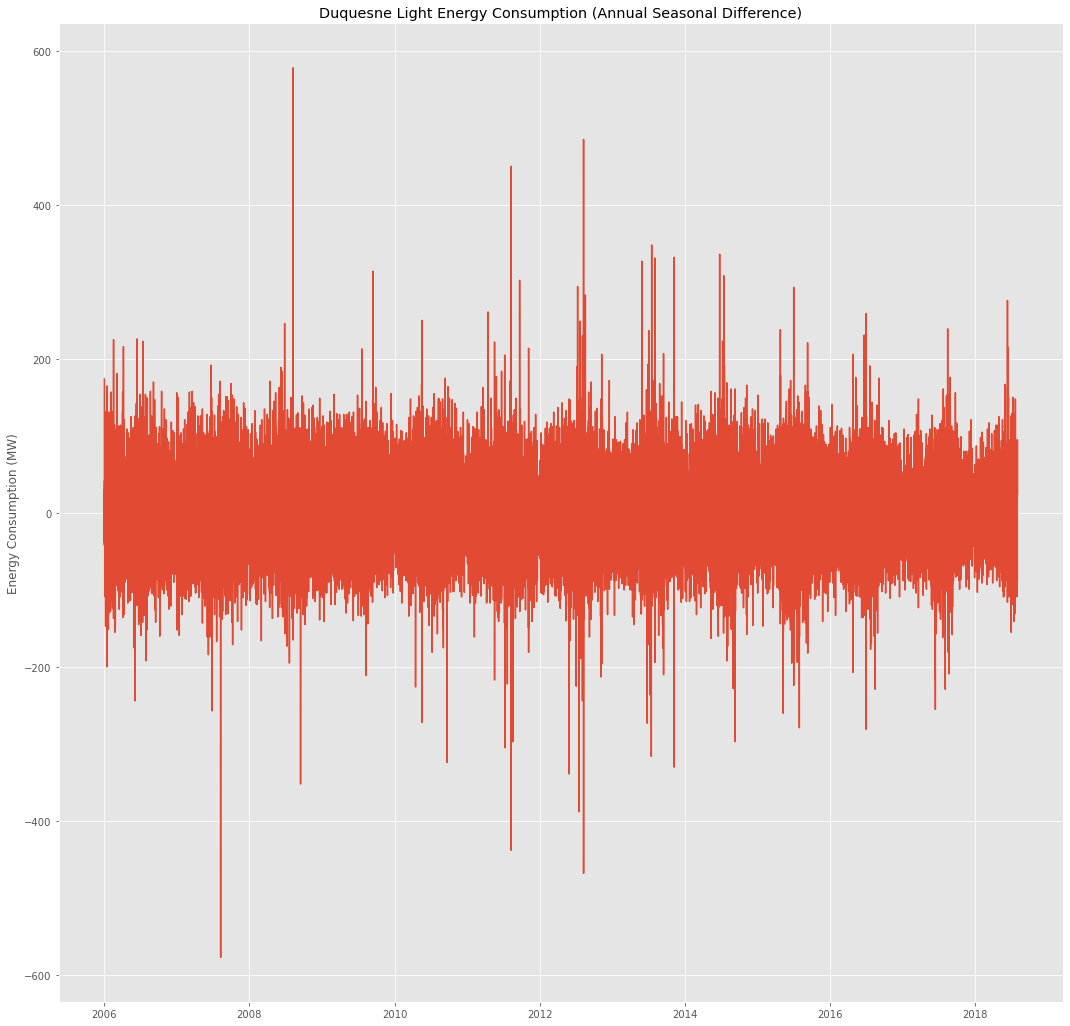

In [25]:
duq_df['seasonal_first_difference'] = duq_df['first_difference'] - duq_df['first_difference'].shift(ANNUAL_SHIFT)
plt.plot(duq_df.index, duq_df['seasonal_first_difference'])
plt.title('Duquesne Light Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/annual_seasonal_difference.png')
plt.show()

In [26]:
adf_result = adfuller(duq_df['seasonal_first_difference'][ANNUAL_SHIFT+1:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -57.19282050213518
p-value: 0.0


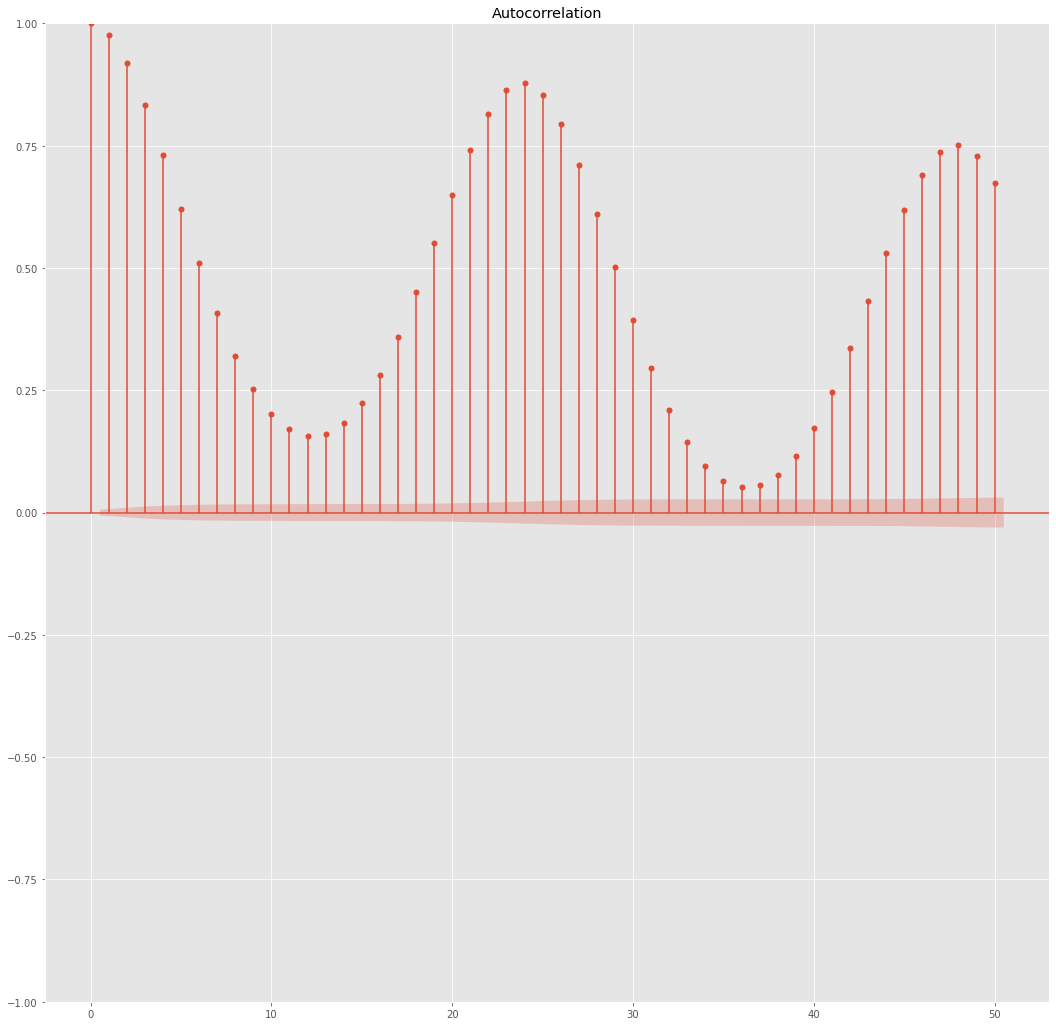

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(duq_df['DUQ_MW'], lags=50)
plt.savefig('images/acf.png')
plt.show()

/Users/hardikmanthrani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


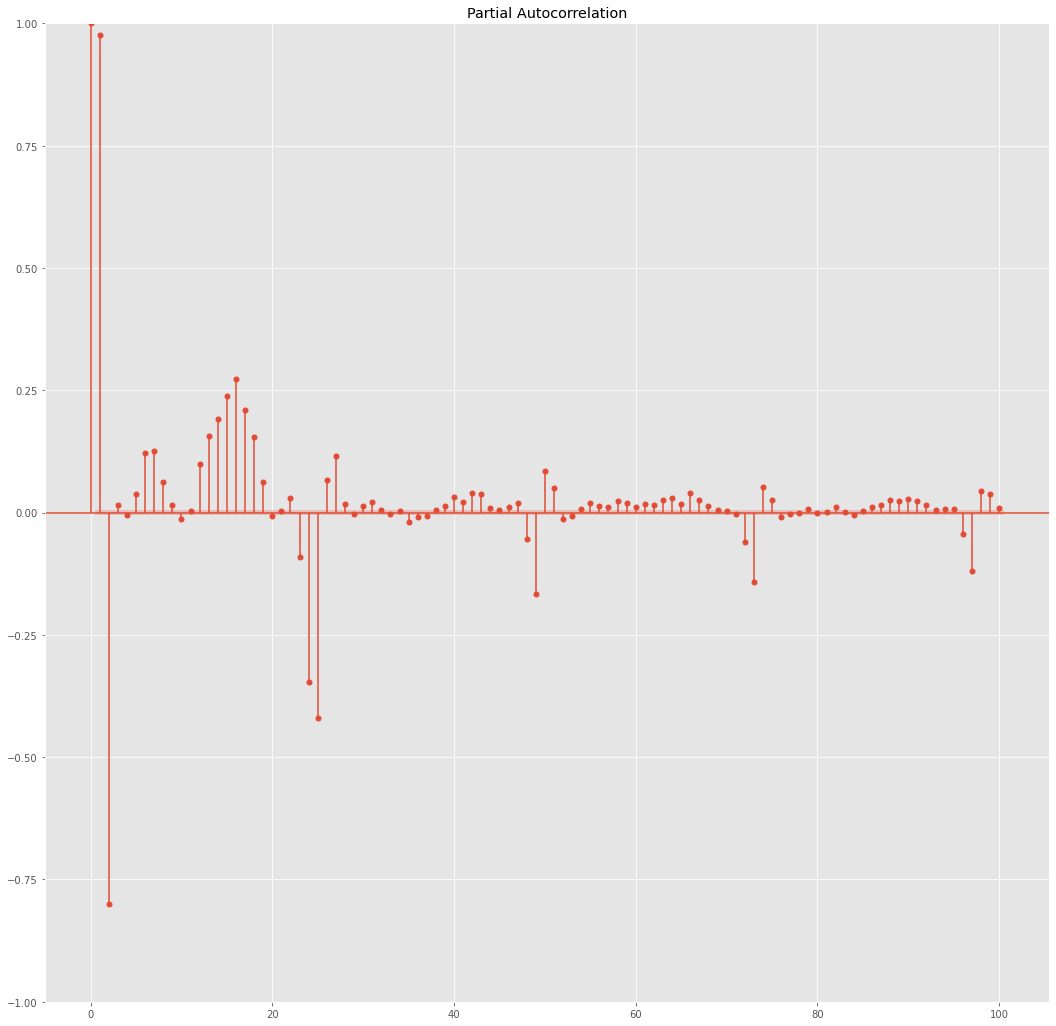

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(duq_df['DUQ_MW'], lags=100)
plt.savefig('images/pacf.png')
plt.show()

## Baseline ARIMA Models

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime
import math

train_series = duq_df.loc[(duq_df.index >= datetime(2014, 1, 1)) & (duq_df.index < datetime(2018, 8, 1)), 'DUQ_MW']
test_series = duq_df.loc[(duq_df.index >= datetime(2018, 8, 1)), 'DUQ_MW']

MSE: 20323.703
RMSE: 142.561


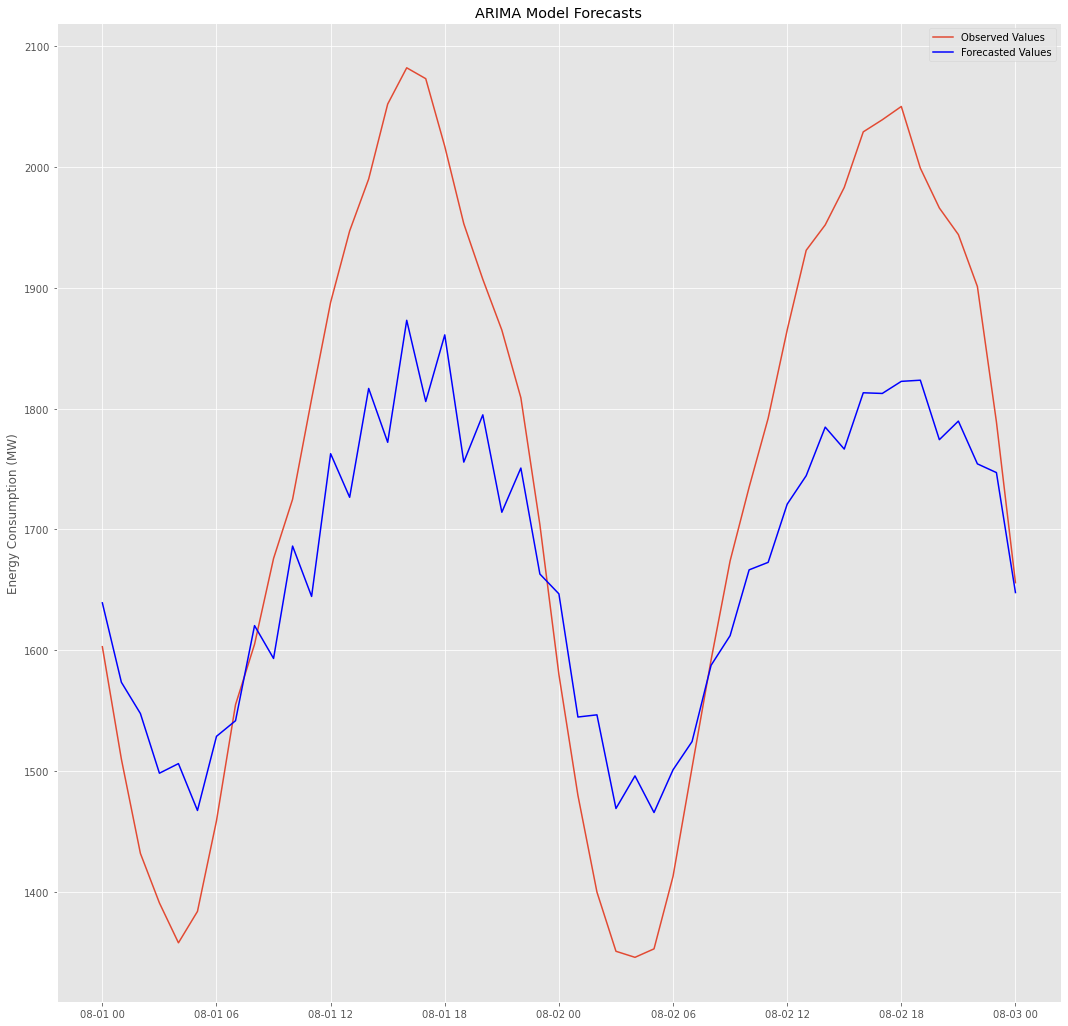

In [32]:
arima_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    arima_preds.append(output[0])
    history.append(test_series[t])

arima_pred_series = pd.Series(arima_preds, index=test_series.index)

error = mean_squared_error(test_series, arima_pred_series)
RMSE = math.sqrt(error)
print('MSE: %.3f' % error)
print('RMSE: %.3f' % RMSE)

plt.plot(test_series, label='Observed Values')
plt.plot(arima_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/arima.png')
plt.show()